In [1]:
#!pip install keras tensorflow

In [2]:
import numpy as np
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
data = pd.read_csv('../datasets/train.txt', sep='\t', header=None, names=['Title', 'Origin', 'Genre', 'Director', 'Plot'])
data.head()

,Title,Origin,Genre,Director,Plot
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...
3,Gang,Bollywood,crime,Mazhar Khan,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Intimate Relations,British,drama,Charles Frank,Crisis in a middle-class family when the son f...


In [4]:
stop_words = ["the", "to", "of", "a", 'and', 'is', 'his', 'in', 'he', 
            'that', 'her', "with", "by", "for", "him", "the", "as", "who",
            "on", "she", "but", "from", "has", "they", "an", "at", "their", "are",
            "into", "he", "out", "it", "up", "be", "was", "when", "not", "them", "which",
            "then", "after", "about", "where", "one", "have", "When", "After", "tells", "him.",
            "back", "She", "will", "while", "all", "two", "In", "had", "been", "They",
            "get", "only", "also", "before", "off", "being", "As", "goes", "takes",
            "this", "other", "take", "tries", "A", "her.", "go", "gets", "can", "man", "so",
            "over", "through", "down", "help", "new", "him,", "now", "comes", "next", "himself",
            "later", "however", "away", "there", "during", "both", "first", "again", "no", "way", "own",
            "some", "another", "more", "becomes", "make", "does", "what", "begins", "meanwhile", "just",
            "asks", "if", "because", "soon", "having", "its", "eventually", "come", "still", "between", "father",
            "house", "finds"
            ]

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.strip(' ')
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

data['Clean_Plot'] = data['Plot'].apply(preprocess_text)

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_162422/1285755728.py:27: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [5]:
# prints clean plot head

data['Clean_Plot'].head()

0    sekhar tarun graduate iim works business manag...
1    kris fowles katie cassidy springwood diner mee...
2    cynthia traumatized death baby leaving bathtub...
3    four friends gangu jackie shroff abdul nana pa...
4    crisis middle class family son falls love mist...
Name: Clean_Plot, dtype: object

## Tf-idf will give us the embeddings

In [6]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Genre'], shuffle=True)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

label_encoder = LabelEncoder()
label_encoder.fit(data['Genre'])

y_train = label_encoder.transform(train_data['Genre'])
y_test = label_encoder.transform(test_data['Genre'])

# TF-IDF vectorization
tfidf = TfidfVectorizer(min_df=20, stop_words=stop_words, ngram_range=(1, 3))
X_train = tfidf.fit_transform(train_data['Clean_Plot'])
X_test = tfidf.transform(test_data['Clean_Plot'])


Accuracy: 0.6500932256059664
Classification Report:
               precision    recall  f1-score   support

      action       0.64      0.66      0.65       212
   animation       0.80      0.56      0.66       107
      comedy       0.60      0.55      0.57       239
       crime       0.63      0.42      0.50       108
       drama       0.53      0.61      0.57       335
      horror       0.77      0.87      0.82       222
     romance       0.54      0.55      0.55       177
      sci-fi       0.70      0.44      0.54        43
     western       0.87      0.93      0.90       166

    accuracy                           0.65      1609
   macro avg       0.68      0.62      0.64      1609
weighted avg       0.65      0.65      0.65      1609



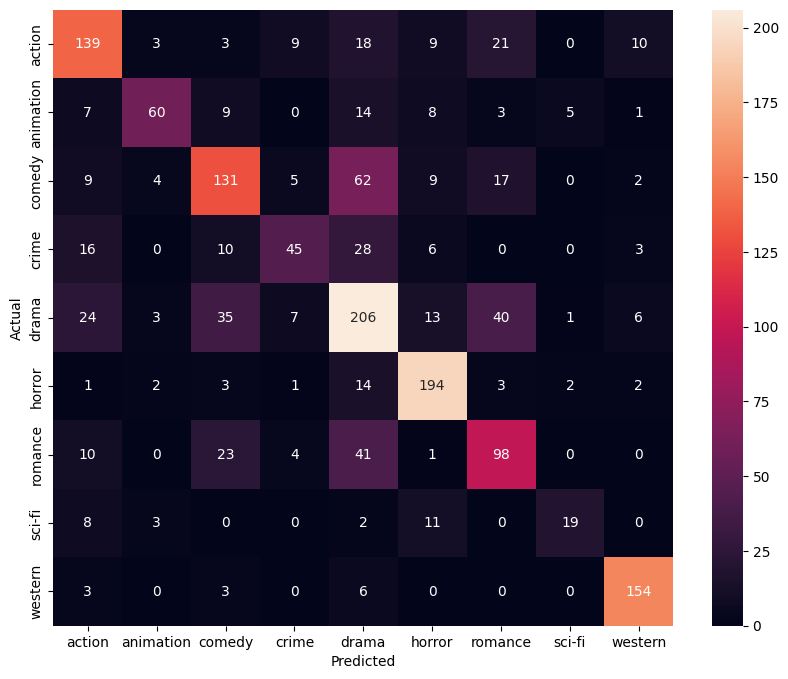

In [7]:
from sklearn.naive_bayes import MultinomialNB

# adjusting alpha got me way better results to avoid smoothing a lot
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Let's analyze the mispredictions

In [8]:
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

misclassified_indices = np.where(y_pred != y_test)[0]

mispredictions_df = pd.DataFrame({
    'Plot': test_data['Plot'].iloc[misclassified_indices].values,
    'Clean Plot': test_data['Clean_Plot'].iloc[misclassified_indices].values,
    'True Genre': y_test_decoded[misclassified_indices],
    'Predicted Genre': y_pred_decoded[misclassified_indices]
})

# displays a sample of them
print("\nSample mispredictions:")
mispredictions_df.head()

# writes them to a file
mispredictions_df.to_csv('mispredictions.csv', index=False)


Sample mispredictions:


## Testing Time (these won't be the submitted predictions)

In [9]:
test_data = pd.read_csv('../datasets/test_no_labels.txt', 
                        sep='\t', header=None, names=['Title', 'Origin', 'Director', 'Plot'])

test_data.head()

,Title,Origin,Director,Plot
0,Bava Nachadu,Telugu,KS Ravikumar,Ajay (Nagarjuna Akkineni) is an adman (directo...
1,Quick,South_Korean,Unknown,"Seoul, 2004. A group of bikers are joy-riding ..."
2,Doraemon: Nobita's Great Battle of the Mermaid...,Japanese,Unknown,"The film opens with a sunken ship, in which a ..."
3,Little School Mouse,American,Hanna-Barbera,Jerry decides to school Tuffy in the basics of...
4,The Little Damozel,British,Herbert Wilcox,Gambler Recky Poole (James Rennie) accepts a b...


In [10]:
# preprocess exactly the same as the training set was preprocessed
test_data['Clean_Plot'] = test_data['Plot'].apply(preprocess_text)
test_data['Clean_Plot'].head()

0    ajay nagarjuna akkineni adman director actor d...
1    seoul group bikers joy riding streets leader t...
2    film opens sunken ship shark swimming octopus ...
3    jerry decides school tuffy basics outwitting c...
4    gambler recky poole james rennie accepts bet m...
Name: Clean_Plot, dtype: object

In [11]:
# transform the test data using the same TfidfVectorizer
X_test = tfidf.transform(test_data['Clean_Plot']).toarray()

# predict the genres of the test data
y_pred = nb_classifier.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred)
y_pred[:5]

array(['romance', 'action', 'animation', 'animation', 'comedy'],
      dtype=object)

In [12]:
# save the predictions to a file -- the only content of the file should be a single word with the predicted genre per line

with open('predictions.txt', 'w') as f:
    for genre in y_pred:
        f.write(genre + '\n')